### Transfer Learning with Pytorch

### 1.What is Transfer Learning 

- Transfer Learning is speciafically using a neural network that has been pre-trained on a much larger dataset.
- The main benefit of using transfer learning is that the neural network  has already learn the important features from large dataset.
- When we use that netwrork on our own dataset, we just need to tweak a few things to achieve good results.

![](https://miro.medium.com/max/1400/1*Ww3AMxZeoiB84GVSRBr4Bw.png)

### 2.When to use Transfer Learning?
- It used when dataset is very small.
- Due to huge computational Power.

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### Dataset used in pretrained Model

![](https://debuggercafe.com/wp-content/uploads/2019/12/imagenet.png)

* Images : 14 Millions
* classes : 22000
* Organize : [ILSVRC](https://image-net.org/challenges/LSVRC/2017/index)

### 1.Load Libraries

In [1]:
# torch loaded..!!!
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

# torchvision loaded..!!!
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

# other libraries loaded,,,!!!
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


### 2.Check the GPU availability

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 3. Download the dataset and prepare

In [3]:
# Tranforms for the training, validation, and testing sets
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [4]:
# Download the training data and testing data
trainset = torchvision.datasets.CIFAR10(root='./data_new', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data_new', train=False, download=True, transform=transform)

170499072it [00:28, 5990303.03it/s]                               


Extracting ./data_new\cifar-10-python.tar.gz to ./data_new
Files already downloaded and verified


In [5]:
# Load the data using DataLoader
trainLoader = torch.utils.data.DataLoader(trainset, batch_size= 32, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

### 4.Downloading the ResNet18 Network
![](https://i.imgur.com/XwcnU5x.png)

In [6]:
for batch_1 in trainLoader:
    batch = batch_1
    break

print(f"Image shape:{batch[0].shape}") # Image pixels -> (batch, channel, height, width)
print(f"Label shape:{batch[1].shape}") # Label -> (batch, 1)

Image shape:torch.Size([32, 3, 224, 224])
Label shape:torch.Size([32])


In [7]:
resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)
resnet18.to(device)
print(str(summary(resnet18.to(device), (3, 224, 224), depth=1, device=device)))

C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          147,968
├─Sequential: 1-6                        [-1, 128, 28, 28]         525,568
├─Sequential: 1-7                        [-1, 256, 14, 14]         2,099,712
├─Sequential: 1-8                        [-1, 512, 7, 7]           8,393,728
├─AdaptiveAvgPool2d: 1-9                 [-1, 512, 1, 1]           --
├─Linear: 1-10                           [-1, 10]                  5,130
Total params: 11,181,642
Trainable params: 11,181,642
Non-trainable params: 0
Total mult-adds (M): 140.34
Input size (MB): 0.57
Forward/backward pass size (MB): 12.25
Params size (MB): 42.65
Est

### 5.Freezing Convolution Weights
- Original dataset contains 1000 Classes.
- Last layer set `resnet18.fc = Linear(512,10)`.
- Freeze all the weights of convolution block.

In [8]:
# Freeze parameters so we don't backprop through them
# for param in resnet18.parameters():
#     param.requires_grad = False

### 6.Optimizer and Loss Function

In [9]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

### 7.Training and Validation

In [28]:
def validation(model, testLoader):
    model.eval()
    val_running_loss = 0
    val_running_correct = 0
    # 1. Load the data
    for int, data in enumerate(testLoader, 0):
        # 2. Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 3. Forward pass
        outputs = model(inputs)
        
        # 4. Calculate the loss
        loss = loss_fn(outputs, labels)
        
        # 5. Calculate the val_loss
        val_running_loss += loss.item()
        
        # 6. torch.max returns the max value and the index of the max value
        _, preds = torch.max(outputs, 1)
        
        # 7. Calculate the val correct  
        val_running_correct += (preds == labels).sum().item()
    
    val_loss = val_running_loss / len(testLoader.dataset)
    val_accuracy = val_running_correct / len(testLoader.dataset)
        
    return val_loss, val_accuracy
    

 In validation method we are calculating the loss and accuracy. but we are not doing any backpropagating the gradient, backpropagation is only required during training

In [29]:
def fit(model, trainLoader):
    model.train()
    train_running_loss = 0
    train_running_correct = 0
    # 1. Load the data
    for i, data in enumerate(trainLoader, 0):
        # 2. Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 3. zero the parameter gradients
        optimizer.zero_grad()
        
        # 4. forward pass
        output = model(inputs)
        
        # 5. Calculate the loss
        loss = loss_fn(output, labels)
        train_running_loss += loss.item()
        
        # 6. predict the output
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds - labels).sum().item()
        
        # 7. backward pass
        loss.backward()
        
        # 8. optimize the weights
        optimizer.step()
        
    train_loss = train_running_loss / len(trainLoader.dataset)
    train_accuracy = train_running_correct/len(trainLoader.dataset)
    # print(f"Train Loss: {train_loss:.2f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy       
    

* `fit()` method calculating gradient and backpropagation.
* `fit(), validation()` will keep returning the loss and accuracy values for each epoch.

In [31]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    start_epoch = time.time()
    train_epoch_loss, train_epoch_accuracy = fit(resnet18, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validation(resnet18, testLoader)
    i = epoch + 1
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    end_epoch = time.time()
    total_time = end_epoch - start_epoch
    print(f"Epoch : {i}/{10} ETA:{total_time:.2f} seconds, Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}, Val Loss: {val_epoch_loss}, Val Acc: {val_epoch_accuracy}")
    
end = time.time()
print((end-start)/60, 'minutes')

Epoch : 1/10 ETA:144.10 seconds, Train Loss: 0.0184, Train Acc: 0.01, Val Loss: 0.018194763697683813, Val Acc: 0.8012
Epoch : 2/10 ETA:151.63 seconds, Train Loss: 0.0183, Train Acc: 0.01, Val Loss: 0.017984453096985816, Val Acc: 0.8001
Epoch : 3/10 ETA:164.47 seconds, Train Loss: 0.0180, Train Acc: 0.02, Val Loss: 0.01749786235243082, Val Acc: 0.8105
Epoch : 4/10 ETA:174.91 seconds, Train Loss: 0.0180, Train Acc: 0.01, Val Loss: 0.017611042676866053, Val Acc: 0.8067
Epoch : 5/10 ETA:170.74 seconds, Train Loss: 0.0180, Train Acc: 0.01, Val Loss: 0.017491949382424356, Val Acc: 0.809
Epoch : 6/10 ETA:170.06 seconds, Train Loss: 0.0179, Train Acc: 0.01, Val Loss: 0.01748853136599064, Val Acc: 0.807
Epoch : 7/10 ETA:166.22 seconds, Train Loss: 0.0177, Train Acc: 0.01, Val Loss: 0.01750915951281786, Val Acc: 0.8109
Epoch : 8/10 ETA:166.30 seconds, Train Loss: 0.0177, Train Acc: 0.01, Val Loss: 0.017499353241920472, Val Acc: 0.8103
Epoch : 9/10 ETA:163.44 seconds, Train Loss: 0.0178, Train Ac

### 8. Plot the graph

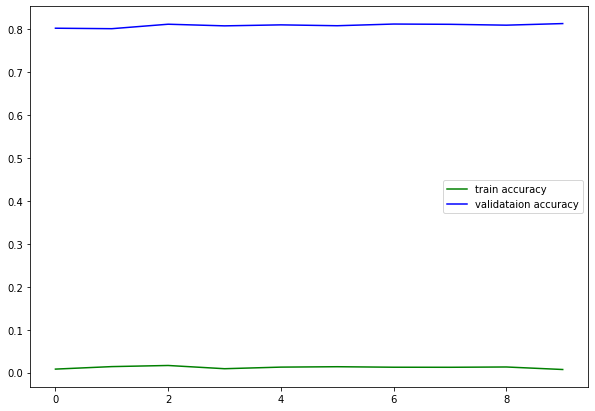

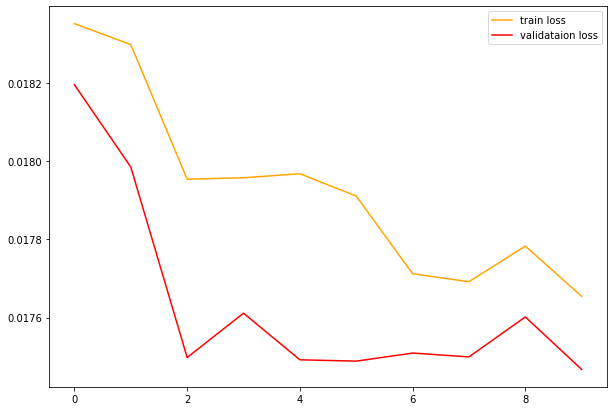

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()